In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
import statistics
import math
from collections import deque


plt.style.use(style="fivethirtyeight")
%matplotlib inline

SEQ_LEN = 30  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict

In [2]:
btc_df = pd.read_csv("BTC-USD.csv")

In [6]:
# btc_df.head()
# btc_df.info()

## Clean the data

In [3]:
# remove unnecessary columns.
btc_df.drop(["Open", "High", "Low", "Adj Close"], axis=1, inplace=True)
# find rows with nan values
btc_df[btc_df.isnull().any(axis=1)]
# fill nan with previously known values.
btc_df.fillna(method="ffill", inplace=True)

btc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2488 entries, 0 to 2487
Data columns (total 3 columns):
Date      2488 non-null object
Close     2488 non-null float64
Volume    2488 non-null float64
dtypes: float64(2), object(1)
memory usage: 58.4+ KB


## Plot the price over time

Text(0, 0.5, 'Close Price')

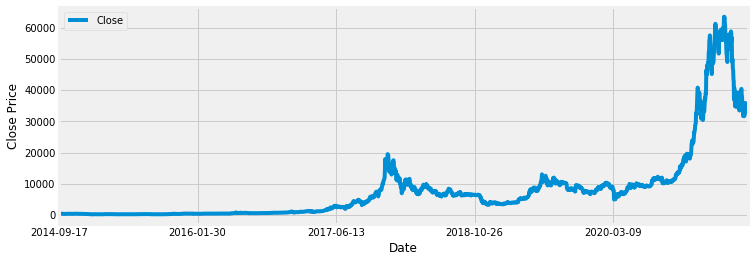

In [466]:
fig, ax = plt.subplots(figsize=(11,4))
btc_df.plot(x="Date", y="Close", ax=ax)
ax.set_ylabel("Close Price")

## Add feature - Price Returns
The percent change in price relative to the previous day

In [5]:
btc_df["Price Returns"] = btc_df["Close"].pct_change()
btc_df.head()

,Date,Close,Volume,Price Returns
0,2014-09-17,457.334015,21056800.0,NaN
1,2014-09-18,424.440002,34483200.0,-0.071926
2,2014-09-19,394.795990,37919700.0,-0.069843
3,2014-09-20,408.903992,36863600.0,0.035735
4,2014-09-21,398.821014,26580100.0,-0.024659


### Analize price returns

In [6]:
btc_df["Price Returns"].describe()

count    2487.000000
mean        0.002502
std         0.039258
min        -0.371695
25%        -0.012616
50%         0.001988
75%         0.018028
max         0.252472
Name: Price Returns, dtype: float64

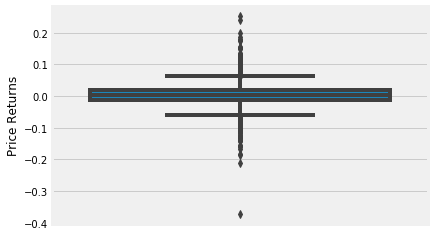

In [7]:
sns.boxplot(x="Price Returns", data=btc_df, orient="v")

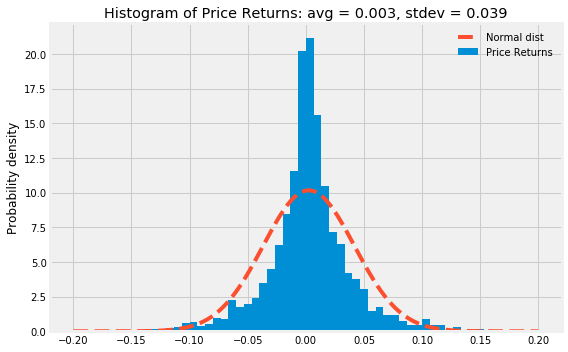

In [8]:
# Plot a histogram of price returns

x = btc_df["Price Returns"]

num_bins = 60

fig, ax = plt.subplots(figsize=(8,5))

# the histogram of the data
ax.hist(x, num_bins, density=True, range=(-0.2,0.2))

# Compare to a normal distribution with the same mean and stdev.
np.random.seed(196)
x_axis = np.arange(-0.2, 0.2, 0.0001)
mu = btc_df["Price Returns"].mean()
sigma = btc_df["Price Returns"].std()

y = norm.pdf(x_axis, mu, sigma)
ax.plot(x_axis, y, '--', label="Normal dist")
ax.set_ylabel('Probability density')
ax.set_title(f'Histogram of Price Returns: avg = {round(mu, 3)}, stdev = {round(sigma, 3)}')
ax.legend(loc='best', frameon=False)
fig.tight_layout()

## Add logarithmic returns column and analyze
**Usually more convient to work with (comparing to raw-returns) statistically and mathematically wise, algorithmicaly wise and more.

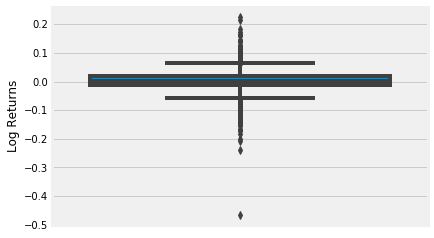

In [9]:
btc_df["Log Returns"] = np.log(1 + btc_df["Price Returns"])
# btc_df.head(10)
sns.boxplot(x="Log Returns", data=btc_df, orient='v')

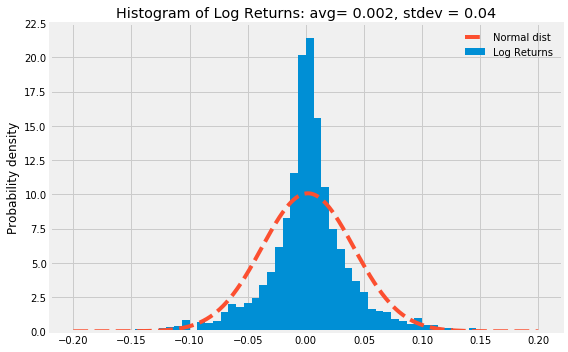

In [10]:
fig, ax = plt.subplots(figsize=(8,5))
x = btc_df["Log Returns"]

# the histogram of the data
ax.hist(x, num_bins, density=True, range=(-0.2,0.2))

# Compare to a normal distribution
mu = btc_df["Log Returns"].mean()
sigma = btc_df["Log Returns"].std()

y = norm.pdf(x_axis, mu, sigma)
ax.plot(x_axis, y, '--', label="Normal dist")
ax.set_ylabel('Probability density')
ax.set_title(f'Histogram of Log Returns: avg= {round(mu, 3)}, stdev = {round(sigma, 3)}')
ax.legend(loc='best', frameon=False)
fig.tight_layout()

## Preprocess the data for the model

### Add a "Future" price column for labeling

In [69]:
btc_df["Future"] = btc_df["Close"].shift(-FUTURE_PERIOD_PREDICT)
btc_df.head()

,Date,Close,Volume,Price Returns,Log Returns,Future
0,2014-09-17,457.334015,21056800.0,NaN,NaN,424.440002
1,2014-09-18,424.440002,34483200.0,-0.071926,-0.074643,394.795990
2,2014-09-19,394.795990,37919700.0,-0.069843,-0.072402,408.903992
3,2014-09-20,408.903992,36863600.0,0.035735,0.035111,398.821014
4,2014-09-21,398.821014,26580100.0,-0.024659,-0.024968,402.152008


I'll be using only Close and Log Returns as the features for the sake of the demonstration, however many more features can be added based on this data set alone, for example we can use the volume (normalized - as we did with the price).

In [157]:
df = btc_df[["Date","Close", "Log Returns", "Future"]].copy()
df.dropna(inplace=True)
df.head()

,Date,Close,Log Returns,Future
1,2014-09-18,424.440002,-0.074643,394.795990
2,2014-09-19,394.795990,-0.072402,408.903992
3,2014-09-20,408.903992,0.035111,398.821014
4,2014-09-21,398.821014,-0.024968,402.152008
5,2014-09-22,402.152008,0.008317,435.790985


### Split the data to training and validation sets

In [158]:
split_index = int(0.9 * df.shape[0]) # 10% of the data will be for validation. This will be last 10% of the rows.
df_train = df[(df.index < split_index)]
df_test = df[(df.index >= split_index)]

df_train.shape, df_test.shape

((2236, 4), (250, 4))

### Scaling and creating sequences
Scaling is done after the split to train and validation sets in order to prevent bias.

In [160]:
from sklearn.preprocessing import MinMaxScaler, scale

scaler = MinMaxScaler(feature_range=(0,1))

def preprocess_df(df):
    """scale and create sequential data and labels (X,y) to be used by the model"""
    
    to_scale = df[["Close", "Log Returns", "Future"]].values
    scaled = scaler.fit_transform(to_scale)
    
    # create the sequences
    sequential_data = []
    prev_days = deque(maxlen=SEQ_LEN)  # once it contains maxlen items, the next item added will pop out the first one.
    for i in scaled:
        prev_days.append(i[:-1])
        if len(prev_days) == SEQ_LEN:  # when the deque is full we can create a sequence
            sequential_data.append([np.array(prev_days), i[-1]])
    
    X = []
    y = []
    
    for seq, target in sequential_data:
        X.append(seq)
        y.append(target)
    
    return np.array(X), np.array(y)

### Create the sets for the model

In [161]:
X_train, y_train = preprocess_df(df_train)
X_test, y_test = preprocess_df(df_test)

In [162]:
X_train.shape, y_train.shape
# X_test.shape, y_test.shape

((2207, 30, 2), (2207,))

### Creating the model
After a series of changes and trial and error, these are the parameters I chose for the model.

In [236]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

EPOCHS = 40
BATCH_SIZE = 32

In [237]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=X_train.shape[1:]))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1))

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='mean_squared_error', optimizer=opt)

In [238]:
history = model.fit(
    X_train, y_train,
    batch_size=BATCH_SIZE, epochs=EPOCHS,
    validation_data=(X_test, y_test))

Epoch 1/40
69/69 [==============================] - 13s 131ms/step - loss: 0.0159 - val_loss: 0.0171
Epoch 2/40
69/69 [==============================] - 7s 107ms/step - loss: 0.0025 - val_loss: 0.0166
Epoch 3/40
69/69 [==============================] - 5s 67ms/step - loss: 0.0023 - val_loss: 0.0151
Epoch 4/40
69/69 [==============================] - 5s 68ms/step - loss: 0.0022 - val_loss: 0.0150
Epoch 5/40
69/69 [==============================] - 3s 47ms/step - loss: 0.0021 - val_loss: 0.0147
Epoch 6/40
69/69 [==============================] - 6s 81ms/step - loss: 0.0019 - val_loss: 0.0153
Epoch 7/40
69/69 [==============================] - 3s 47ms/step - loss: 0.0018 - val_loss: 0.0147
Epoch 8/40
69/69 [==============================] - 5s 69ms/step - loss: 0.0017 - val_loss: 0.0153
Epoch 9/40
69/69 [==============================] - 4s 52ms/step - loss: 0.0016 - val_loss: 0.0156
Epoch 10/40
69/69 [==============================] - 3s 48ms/step - loss: 0.0015 - val_loss: 0.0142
Epoch 

### Analyze performance

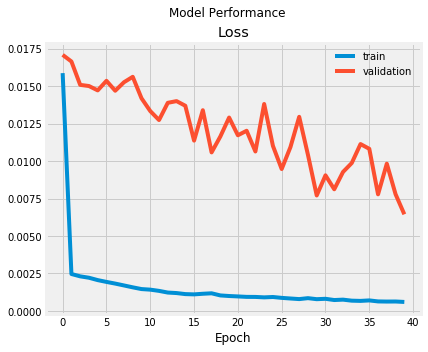

In [467]:
fig, ax = plt.subplots(figsize=(6,5))
fig.suptitle("Model Performance")

ax.plot("loss", data=history.history, label="train")
ax.plot("val_loss", data=history.history, label="validation")
ax.set_title("Loss")
ax.set_xlabel("Epoch")
ax.legend(frameon=False)

In [240]:
test_predict = model.predict(X_test)

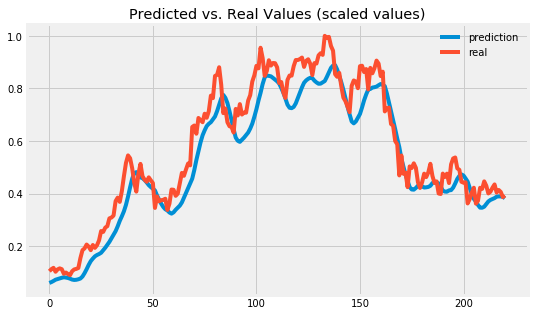

In [241]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot(test_predict, label="prediction")
ax.plot(y_test, label="real")
ax.set_title("Predicted vs. Real Values (scaled values)")
plt.legend(frameon=False)

### Predict price of future dates
First lets create a sequence to predict the first day outside of the data - July 10th 2021

In [365]:
# a sequence up to last date on the original data - July 9th
X = btc_df[["Close", "Log Returns"]].iloc[-SEQ_LEN:].values
X_scaled = scaler.fit_transform(X)

In [358]:
# Predict the price for July 10th
july_10_prediction = model.predict(X_scaled.reshape(1,X_scaled.shape[0],X_scaled.shape[1]))

In [359]:
# unscale to get the price
to_rescale = np.array([[july_10_prediction[0][0], 0]]) # create an object which can be fed to the scaler
july_10_prediction = scaler.inverse_transform(to_rescale)[0][0]
july_10_prediction

34100.30022619148

In [321]:
# New data of BTC-USD for dates not in the previous dataset
new_df = pd.read_csv("BTC-USD_new.csv")
new_df.drop(["Open", "High", "Low", "Adj Close"], axis=1, inplace=True)
new_df.head()

,Date,Close,Volume
0,2021-07-09,33798.011719,27436021028
1,2021-07-10,33520.519531,22971873468
2,2021-07-11,34240.187500,20108729370
3,2021-07-12,33155.847656,24321499537
4,2021-07-13,32702.025391,19120856669


In [469]:
july_10_prediction/new_df.iloc[1,1] - 1

0.01729629204151495

So the predicted value is pretty close, however the model predicted an increase in price, while it actually decreased.

## Predicting the close prices of new data


### 1. Based on predicted values (unsupervised)
Let's have the model predict the close prices of all the new dates. 
We'll use the sequence that was created for predicting the close price of July 10th. On every iteration we'll have the model predict a new value, and replace the "oldest" value in the sequence with the predicted value to create a new sequence.

In [362]:
def predict_ahead(num_of_days_ahead, first_seq):
    
    seq = first_seq.copy()
    predicted_values = []
    # add a real close price of the last date on the old df to compute the first Log Return.
    predicted_values.append(new_df.loc[0, "Close"])
    
    for i in range(num_of_days_ahead):
        scaled_value, value = predict_and_unscale(seq)
        
        # Compute Log return
        log_return = np.log(value/predicted_values[i])
        
        # add [scaled_value, log_return] to end of the seq (keeping it the same size)
        seq = np.roll(seq, -1, axis=0)  # example: [1,2,3,4] --> [2,3,4,1]
        seq[-1] = [scaled_value, log_return]
        
        predicted_values.append(value)
        
    return predicted_values


def predict_and_unscale(seq):
    """use the model to predict on the seq. return scaled and unscaled predicted values"""
    
    scaled_value = model.predict(seq.reshape(1,seq.shape[0],seq.shape[1]))
    to_rescale = np.array([[scaled_value[0][0], 0]])
    unscaled_value = scaler.inverse_transform(to_rescale)[0][0]
    
    return scaled_value, unscaled_value

In [366]:
new_df["Predicted Values"] = predict_ahead(new_df.shape[0]-1, X_scaled)

### 2. Add supervised prediction on these dates
Use real data to create the sequences and predict the new dates' close prices

In [455]:
joined_df =pd.concat([pd.read_csv("BTC-USD.csv"), pd.read_csv("BTC-USD_new.csv").iloc[1:,:]], ignore_index=True)

joined_df["Price Returns"] = joined_df["Close"].pct_change()
joined_df["Log Returns"] = np.log(1 + joined_df["Price Returns"])
joined_df.tail()


def create_sequences(X_scaled):
    """create sequences for the model out of a given scaled set."""

    sequential_data = []
    prev_days = deque(maxlen=SEQ_LEN)
    for i in X_scaled:
        prev_days.append(i)
        if len(prev_days) == SEQ_LEN:
            sequential_data.append(np.array(prev_days))
    
    X = []
    
    for seq in sequential_data:
        X.append(seq)
    
    return np.array(X)


# get only relevant data to create the new sequences, and scale it
new_data_scaler = MinMaxScaler()
new_scaled_X = new_data_scaler.fit_transform(
    joined_df.iloc[-(SEQ_LEN + new_df.shape[0]):][["Close", "Log Returns"]].values)

new_X_test = create_sequences(new_scaled_X)

# use model to get predictions on new data
new_data_predictions = model.predict(new_X_test)

# unscale. need to reshape.
unscaled_new_data_predictions = new_data_scaler.inverse_transform(
    np.array([[x[0],0] for x in new_data_predictions]))

new_predicted_values = [x[0] for x in unscaled_new_data_predictions]
new_df["Supervised Predictions"] = new_predicted_values[:-1]

### Add a random "baseline"

Let's add another "predicted" price column, to be our baseline, which will be a random prediction.
The formula will be:
$ P_{i+1} = P_i + P_i \times r_i$
where P is the price, and r is a normal distributed random variable, with mean and stdev as the mean and stdev of the real returns.

The goal is that the model will perform just a little bit better than a random walk.

In [456]:
new_df["Returns"] = new_df["Close"].pct_change()


def add_rand_close_col(df):
    mu, sigma = df["Returns"].mean(), df["Returns"].std()
    rand_returns = np.random.normal(mu, sigma, df.shape[0])
    rand_close = []
    rand_close.append(df.iloc[0]["Close"]) # the first value is real, not random.
    for i in range(1, df.shape[0]):
        rand_close.append(rand_close[i-1] + rand_close[i-1] * rand_returns[i])
    
    df["Random Close"] = np.array(rand_close)

add_rand_close_col(new_df)
new_df.head()

,Date,Close,Volume,Predicted Values,Returns,Random Close,Supervised Predictions
0,2021-07-09,33798.011719,27436021028,33798.011719,NaN,33798.011719,34131.878983
1,2021-07-10,33520.519531,22971873468,34100.300226,-0.008210,31802.227698,33954.082908
2,2021-07-11,34240.187500,20108729370,33880.763357,0.021469,32720.404870,33781.538951
3,2021-07-12,33155.847656,24321499537,33597.975348,-0.031669,33234.768112,33666.295685
4,2021-07-13,32702.025391,19120856669,33292.701811,-0.013688,32014.469001,33540.102233


### Put it all together on a graph

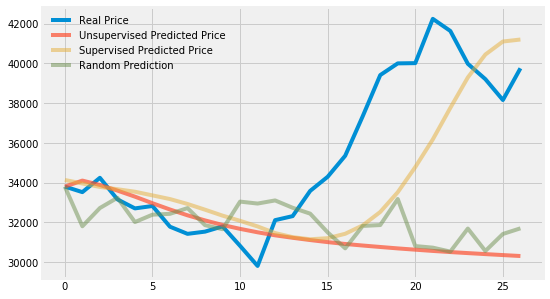

In [464]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot("Close", data=new_df, label="Real Price")
ax.plot("Predicted Values", data=new_df, label="Unsupervised Predicted Price", alpha=0.7)
ax.plot("Supervised Predictions", data=new_df, label="Supervised Predicted Price", alpha=0.5)
ax.plot("Random Close", data=new_df, label="Random Prediction", alpha=0.5)
ax.legend(frameon=False)

In [458]:
from sklearn.metrics import mean_squared_error

root_mse_unsup = np.sqrt(mean_squared_error(new_df["Close"], new_df["Predicted Values"]))
root_mse_supervised = np.sqrt(mean_squared_error(new_df["Close"], new_df["Supervised Predictions"]))
root_mse_rand = np.sqrt(mean_squared_error(new_df["Close"], new_df["Random Close"]))


root_mse_unsup, root_mse_supervised, root_mse_rand

(5820.127078027844, 3083.8552150169717, 5383.7777201489625)

We did it! the model performed (much) better on the data than the random prediction did. Of course that relates to predicting only one day ahead using real data for the previous days.

The other version performed good for sometime, and poorly afterwards (which was somwhat expected).

A different approach to predict n days ahead could be to train n models, each to predict $1 \leq i \leq n$ days ahead.
This could be achieve rather easily with this code - we'll just have to change the prameter FUTURE_PERIOD_PREDICT and run it from the start.